In [2]:
# get access to the complete repo
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(),"..",".."))
main_copy_dir = os.path.join(parent_dir, "main_copy")
octagon_analysis = os.path.join(parent_dir, "octagon_analysis")
sys.path.append(main_copy_dir)
sys.path.append(octagon_analysis)

print("Added paths to sys.path", main_copy_dir, octagon_analysis)

Added paths to sys.path /Users/benny/Desktop/MSc/Project/Git/repos/main_copy /Users/benny/Desktop/MSc/Project/Git/repos/octagon_analysis


In [28]:
# imports
%load_ext autoreload
%autoreload 2

import parse_data.prepare_data as prepare_data
import analysis.opponent_visibility as opponent_visibility
import trajectory_analysis.trajectory_vectors as trajectory_vectors
import trajectory_analysis.trajectory_headangle as trajectory_headangle
import trajectory_analysis.trajectory_direction as trajectory_direction
import data_extraction.trial_list_filters as trial_list_filters
import data_extraction.get_indices as get_indices
from plotting import plot_octagon, plot_trajectory
import utils.cosine_similarity as cosine_similarity
import data_extraction.extract_trial as extract_trial
import parse_data.identify_filepaths as identify_filepaths
import analysis.loser_inferred_choice as loser_inferred_choice
import plotting.flipped_rotated_trajectory_testing_functions as flipped_rotated_trajectory_testing_functions
import plotting.wall_visibility_order_testing_functions as wall_visibility_order_testing_functions


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import globals

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# data folder and filenames
data_folder = "/Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files"

social_files, ordered_solos = identify_filepaths.get_filenames(data_folder=data_folder)

In [ ]:
# single json filename

json_filename = social_files[7]

In [5]:
_, trial_lists = prepare_data.prepare_data(data_folder, social_files, combine=False)

filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250417_1/2025-04-17_12-22-26_CY17_RL17_Social.json
Loading complete.
Preprocessing complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/241112_2/2024-11-12_15-23-24_FA12_SL12_Social.json
Loading complete.
Preprocessing complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/241210_1/2024-12-10_14-21-17_TE10_TK10_Social.json
Loading complete.
Preprocessing complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250509_1/2025-05-09_12-30-13_AM09_MC09_Social.json
Loading complete.
Preprocessing complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250401_2/2025-04-01_15-29-49_AL01_NL01_Social.json
Loading complete.
Prep

In [6]:
_, trial_lists_solos = prepare_data.prepare_data(data_folder, ordered_solos, combine=False)

filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250417_1/2025-04-17_12-09-51_CY17_FirstSolo.json
Loading complete.
Preprocessing complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250417_1/2025-04-17_12-46-27_CY17_SecondSolo.json
Loading complete.
Preprocessing complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250417_1/2025-04-17_12-10-56_RL17_FirstSolo.json
Loading complete.
Preprocessing complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250417_1/2025-04-17_12-46-05_RL17_SecondSolo.json
Loading complete.
Preprocessing complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/241112_2/2024-11-12_15-13-34_FA12_FirstSolo.json
Loading complete.
Preprocessin

**Wall visibility function rework:**

Function: Checks whether the two active walls are continuously visible in a chosen window of time - default is from slice onset and window of size 5 timepoints

Output: 3D binary array, where output[player][wall] accesses the wall visibility of the given wall for the given player across trials 

In [ ]:
def wall_visibility_player_window(trial_list, current_fov, start_index=0, window=5, debug=False):
    ''' 
    Returns 3D binary array for player 0 and player 1 - for wall 1 and wall 2. 
    Column length = length of the session (trial list). 
    Column entry: 1 --> wall visible between trial slice onset (or chosen start index) and end of the chosen window
    Note get_wall_visible extracts trial so that index 0 is slice onset and not trial start.
    '''
    cols = len(trial_list)
    wall_visible_list = np.full((2,2,cols), 0, dtype=int)
    walls_list = np.full((2,cols), 0, dtype=int)
    #dtype=int)
    wall_index = np.full((2,1), np.nan, dtype=int)

    for trial_index in range(len(trial_list)):
        # identify walls for each trial
        walls = get_indices.get_walls(trial=trial_list[trial_index])
        walls_list[0,trial_index] = walls[0]
        walls_list[1,trial_index] = walls[1]

        # take the wall index instead of the wall number, to index wall_visible
        wall_index[0] = walls[0] - 1
        wall_index[1] = walls[1] - 1

        for player_id in [0,1]:
          wall_visible = trajectory_headangle.get_wall_visible(trial_list=trial_list, trial_index=trial_index, trial=None, player_id=player_id, current_fov=current_fov, debug=False)
          
          for wall in [0,1]:
            if debug:
              print(f"checking out wall {wall}")
            if type(wall_visible) == int or type(wall_visible) == float:
              print("wall visible cannot be computed")
              if debug:
                print(f"output type is {type(wall_visible)}")
                print(f"wall visible is buggy for player {player_id} in trial {trial_index}, output is: {wall_visible}")

            else:
              if debug:
                print(f"relevant wall is {walls[wall]}")
                print(f"printing wall visible output for player {player_id} and wall {wall} in trial {trial_index} {wall_visible[wall_index[wall],0:window]}")

              # identify which walls are initially visible
              # changed to all having to be True
              if np.all(wall_visible[wall_index[wall],start_index:window]):
                  wall_visible_list[player_id,wall,trial_index] = 1
     
    return walls_list, wall_visible_list

In [485]:
walls_list, wall_visible_list = wall_visibility_player_window(trial_list, 110, window=5)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [486]:
wall_visible_list

array([[[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
         0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
         0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
         0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]],

       [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
         0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
         0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]]])

**Plotting functions**

plot_headangle_vectors_colour_map: 
--> Plots head angle trajectory for a given trial for a given player, dots for high (red) and low (blue) wall, first smoothed head angle vector in red from the position at slice onset

plot_session_headangle_vectors_colour_map:
--> As above but for all trials within a given session for a given player

In [47]:
def plot_headangle_vectors_colour_map(trial_list=None, trial_index=None, timepoint=0, player_id=0, 
                                        visibility_window=5, headangles_smoothing_window=5,
                                        vector_length=3, step=3, cmap=mpl.cm.plasma, ax=None, debug=False):
    '''
    Plots head angle vectors for a given player in a single trial, using a color map based on timestamps. 
    Plots smoothed head angle vector for given time point. 
    Parameters:
    - trial_list: list of trials 
    - trial_index: desired trial
    - timepoint: time point for which we are interested in seeing the headangle vector.
        Note. Can pass time points obtained from is_player_past_alcove function to check for potential bugs.
    - player_id: ID of the player whose head angles we want to plot
    - vector_length: Scale factor for head angle vectors
    - step: How frequently to plot head angle vectors (e.g., every 3rd point)
    - cmap: Colormap for timestamps.
    '''

    # get walls and visibility
    walls_session, wall_visible_trial_list = wall_visibility_player_window(trial_list, 110, window=visibility_window)

    trial = trial_list[trial_index]

    active_wall_visible = {}

    # extract trial data
    this_trial = extract_trial.extract_trial(trial, trial_list, trial_index)

    trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=this_trial, player_id=player_id)

    # extract head angles for the player
    headangles = trajectory_vectors.extract_trial_player_headangles(trial=trial, player_id=player_id)
    if debug:
        print(f"debugging: headangles are length {len(headangles)}")

    # get smoothed head angle vectors
    trial_player_headangles_smoothed = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles, window_size=headangles_smoothing_window)
    if debug:
        print(f"debugging: trial_player_headangles_smoothed are length {len(trial_player_headangles_smoothed)}")

    # generate timestamps
    timestamps = np.arange(trial_player_headangles_smoothed.shape[1])
    if debug:    
        print(f"debugging: timestamps are length {len(timestamps)}")

    if len(timestamps) > 0:

        # normalize timestamps for colormap
        norm = mpl.colors.Normalize(vmin=min(timestamps), vmax=max(timestamps))
        color_map = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

        # plot octagon
        ax = plot_octagon.plot_octagon(ax=ax)

        # scatter trajectory
        ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)

        # plot head angle vectors at specified intervals with colormap
        for time_index in range(0, trial_player_headangles_smoothed.shape[1], step):
            x_start = trajectory[0,time_index]
            y_start = trajectory[1,time_index]
            x_gradient = trial_player_headangles_smoothed[0, time_index]
            y_gradient = trial_player_headangles_smoothed[1, time_index]

            start = [x_start, y_start]
            end = [x_start + x_gradient * vector_length, y_start + y_gradient * vector_length]

            this_head_angle_vector_coordinates = np.array([start, end])
            if debug:
                print(f"head angle vector coords {this_head_angle_vector_coordinates}")

            # taking x and y coordinates for start and end of vector
            ax.plot(this_head_angle_vector_coordinates[:, 0], 
                    this_head_angle_vector_coordinates[:, 1], 
                    c=color_map.to_rgba(timestamps[time_index]), linewidth=1.3)

        # plot smoothed head angle at defined timepoint in red
        x_start = trajectory[0,timepoint]
        y_start = trajectory[1,timepoint]
        x_gradient = trial_player_headangles_smoothed[0,timepoint-headangles_smoothing_window]
        y_gradient = trial_player_headangles_smoothed[1,timepoint-headangles_smoothing_window]

        start = [x_start, y_start]
        end = [x_start + x_gradient * vector_length*5, y_start + y_gradient * vector_length*5]

        this_head_angle_vector_coordinates = np.array([start, end])
        ax.plot(this_head_angle_vector_coordinates[:, 0], 
                    this_head_angle_vector_coordinates[:, 1], 
                    c="red", linewidth=0.75)

        # plot active walls
        alcove_coordinates = plot_octagon.return_alcove_centre_points()
        walls = get_indices.get_walls(trial=this_trial)
        wall1_index = walls[0] - 1
        wall2_index = walls[1] - 1

        # Use ax.scatter() to plot walls on the correct axis
        ax.scatter(alcove_coordinates[0, wall1_index], alcove_coordinates[1, wall1_index], c='r', s=50, zorder=5)
        ax.scatter(alcove_coordinates[0, wall2_index], alcove_coordinates[1, wall2_index], c='b', s=50, zorder=5)

        # hide spines and ticks
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        if trial_index < len(trial_list):

            active_wall_visible[trial_index] = [
                [walls_session[0][trial_index], wall_visible_trial_list[player_id][0][trial_index]],
                [walls_session[1][trial_index], wall_visible_trial_list[player_id][1][trial_index]]
            ]

        plt.tight_layout()

        plt.show()

    return active_wall_visible

In [29]:
def plot_session_headangle_vectors_colour_map(trial_list=None, player_id=0, 
                                        vector_length=3, step=3, cmap=mpl.cm.plasma, rows=10, cols=10, trial_num_offset=0, debug=False):
    '''
    Plots head angle vectors for a given player in a whole list of trials, using a color map based on timestamps.
    Returns tuples of active walls 1 and 2 with their respective visibility (0 or 1) for each trial index.
    Parameters:
    - trial_list: list of trials 
    - player_id: ID of the player whose head angles we want to plot
    - vector_length: Scale factor for head angle vectors
    - step: How frequently to plot head angle vectors (e.g., every 3rd point)
    - cmap: Colormap for timestamps.
    '''

    fig, axes = plt.subplots(rows, cols, figsize=(20,20))

    # get walls and visibility
    walls_session, wall_visible_trial_list = wall_visibility_player_window(trial_list, 110, window=5)

    active_wall_visible = {}

    for i in range(rows):
        for j in range(cols):
            trial_index = i * cols + j + trial_num_offset

            if trial_index >= len(trial_list):
                continue

            trial = trial_list[trial_index]

            # extract trial data
            this_trial = extract_trial.extract_trial(trial, trial_list, trial_index)

            trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=this_trial, player_id=player_id)

            # extract head angles for the player
            # I am pretty sure this function extracts the trial itself so I feed it the raw trial
            headangles = trajectory_vectors.extract_trial_player_headangles(trial=trial, player_id=player_id)
            if debug:
                print(f"debugging: headangles are length {len(headangles)}")

            # get smoothed head angle vectors
            trial_player_headangles_smoothed = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles, window_size=5)
            if debug:
                print(f"debugging: trial_player_headangles_smoothed are length {len(trial_player_headangles_smoothed)}")

            # generate timestamps
            timestamps = np.arange(trial_player_headangles_smoothed.shape[1])
            if debug:
                print(f"debugging: timestamps are length {len(timestamps)}")

            if len(timestamps) > 0:

                # normalize timestamps for colormap
                norm = mpl.colors.Normalize(vmin=min(timestamps), vmax=max(timestamps))
                color_map = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

                # plot octagon
                ax = plot_octagon.plot_octagon(ax=axes[i,j])

                # scatter trajectory
                ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)

                # plot head angle vectors at specified intervals with colormap
                for time_index in range(0, trial_player_headangles_smoothed.shape[1], step):
                    x_start = trajectory[0,time_index]
                    y_start = trajectory[1,time_index]
                    x_gradient = trial_player_headangles_smoothed[0, time_index]
                    y_gradient = trial_player_headangles_smoothed[1, time_index]

                    start = [x_start, y_start]
                    end = [x_start + x_gradient * vector_length, y_start + y_gradient * vector_length]

                    this_head_angle_vector_coordinates = np.array([start, end])
                    if debug:
                        print(f"head angle vector coords {this_head_angle_vector_coordinates}")

                    # taking x and y coordinates for start and end of vector
                    ax.plot(this_head_angle_vector_coordinates[:, 0], 
                            this_head_angle_vector_coordinates[:, 1], 
                            c=color_map.to_rgba(timestamps[time_index]), linewidth=1.3)

                # plot first smoothed head angle in red
                x_start = trajectory[0,0]
                y_start = trajectory[1,0]
                x_gradient = trial_player_headangles_smoothed[0, 0]
                y_gradient = trial_player_headangles_smoothed[1, 0]

                start = [x_start, y_start]
                end = [x_start + x_gradient * vector_length*5, y_start + y_gradient * vector_length*5]

                this_head_angle_vector_coordinates = np.array([start, end])
                ax.plot(this_head_angle_vector_coordinates[:, 0], 
                            this_head_angle_vector_coordinates[:, 1], 
                            c="red", linewidth=0.75)

                # plot active walls
                alcove_coordinates = plot_octagon.return_alcove_centre_points()
                walls = get_indices.get_walls(trial=this_trial)
                wall1_index = walls[0] - 1
                wall2_index = walls[1] - 1

                # Use ax.scatter() to plot walls on the correct axis
                ax.scatter(alcove_coordinates[0, wall1_index], alcove_coordinates[1, wall1_index], c='r', s=50, zorder=5)
                ax.scatter(alcove_coordinates[0, wall2_index], alcove_coordinates[1, wall2_index], c='b', s=50, zorder=5)

                # hide spines and ticks
                for spine in ax.spines.values():
                    spine.set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])

            if trial_index < len(trial_list):
                
                active_wall_visible[trial_index] = [
                    [walls_session[0][trial_index], wall_visible_trial_list[player_id][0][trial_index]],
                    [walls_session[1][trial_index], wall_visible_trial_list[player_id][1][trial_index]]
                ]

    plt.tight_layout()

    plt.show()

    return active_wall_visible

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


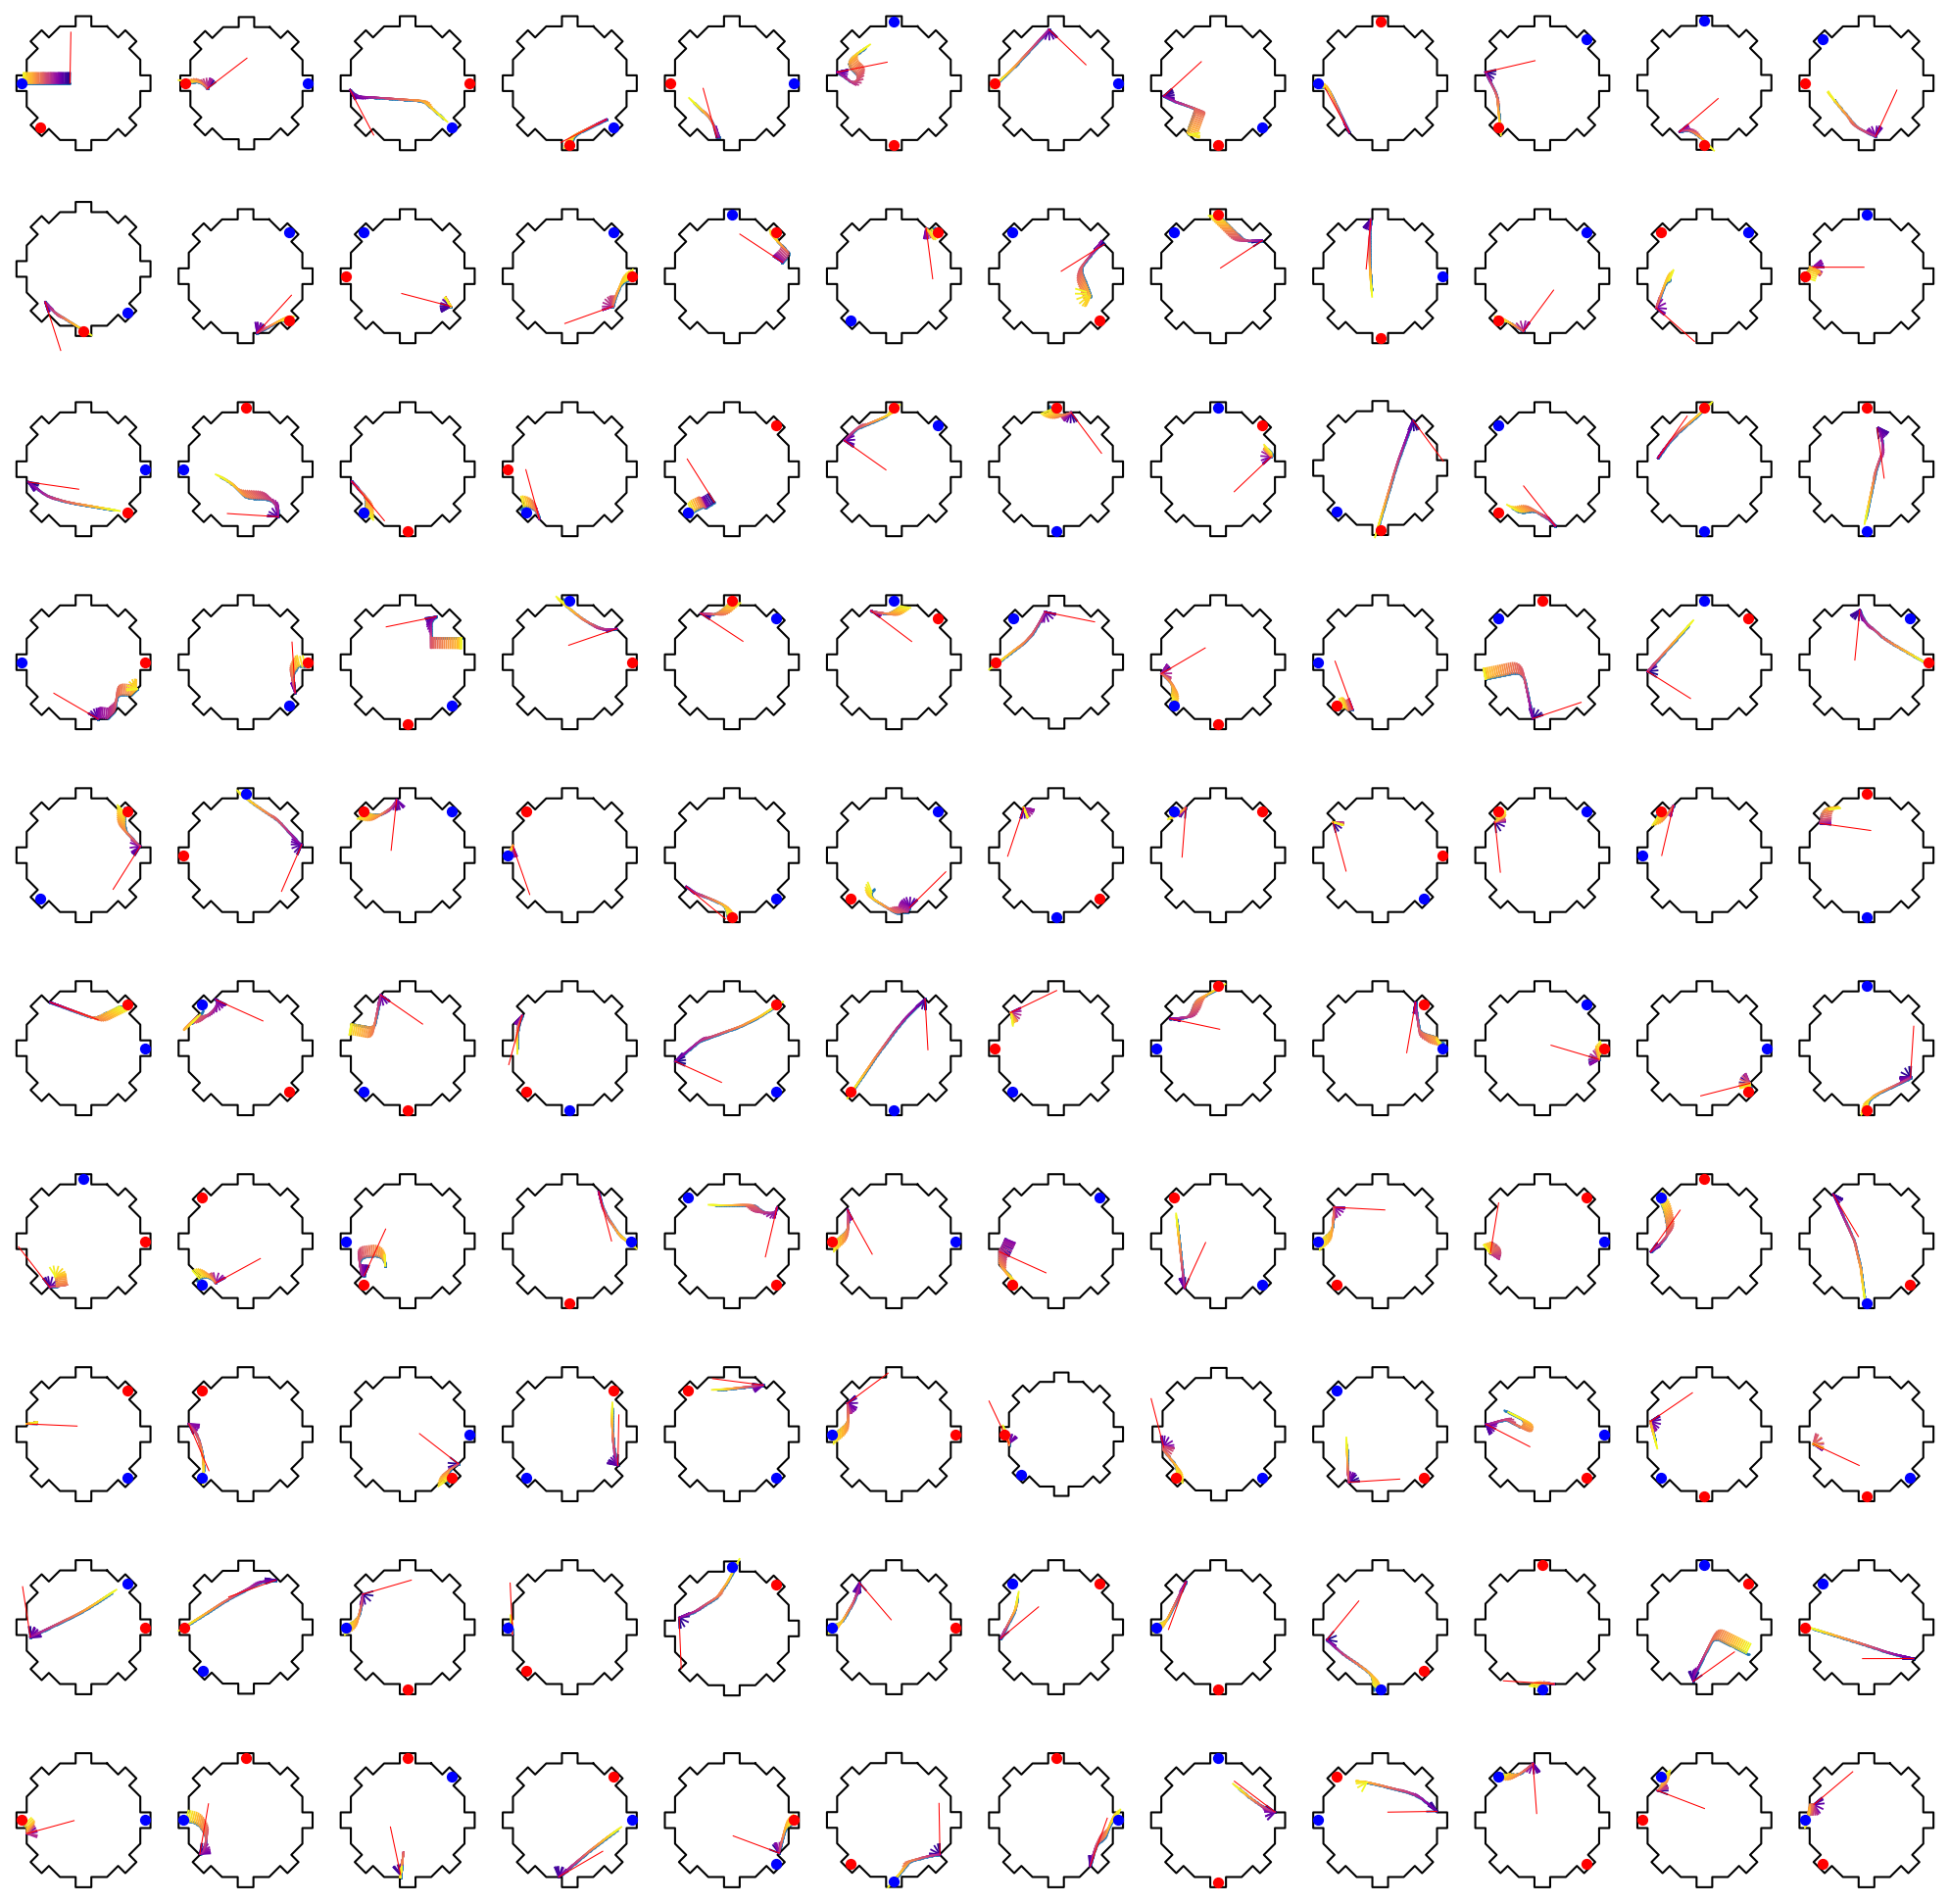

In [519]:
active_wall_visible = plot_session_headangle_vectors_colour_map(trial_list=trial_list, player_id=0,
                                        vector_length=3, step=3, cmap=mpl.cm.plasma, rows=10, cols=12, trial_num_offset=0)

In [329]:
active_wall_visible

{0: [[np.int64(3), np.int64(0)], [np.int64(1), np.int64(1)]],
 1: [[np.int64(2), np.int64(0)], [np.int64(6), np.int64(1)]],
 2: [[np.int64(7), np.int64(1)], [np.int64(3), np.int64(0)]],
 3: [[np.int64(7), np.int64(1)], [np.int64(1), np.int64(0)]],
 4: [[np.int64(7), np.int64(0)], [np.int64(8), np.int64(0)]],
 5: [[np.int64(7), np.int64(0)], [np.int64(6), np.int64(1)]],
 6: [[np.int64(1), np.int64(0)], [np.int64(2), np.int64(0)]],
 7: [[np.int64(2), np.int64(1)], [np.int64(3), np.int64(1)]],
 8: [[np.int64(2), np.int64(1)], [np.int64(3), np.int64(0)]],
 9: [[np.int64(6), np.int64(1)], [np.int64(2), np.int64(0)]],
 10: [[np.int64(8), np.int64(1)], [np.int64(1), np.int64(0)]],
 11: [[np.int64(4), np.int64(0)], [np.int64(5), np.int64(0)]],
 12: [[np.int64(1), np.int64(1)], [np.int64(5), np.int64(0)]],
 13: [[np.int64(6), np.int64(1)], [np.int64(5), np.int64(1)]],
 14: [[np.int64(8), np.int64(1)], [np.int64(2), np.int64(0)]],
 15: [[np.int64(4), np.int64(1)], [np.int64(6), np.int64(1)]],
 1

In [414]:
import math
p1 = (alcoves[0][0], alcoves[1][0])
p2 = (alcoves[0][4], alcoves[1][4])
print(math.dist(p1,p2)/2)

p3 = (alcoves[0][2], alcoves[1][2])
p4 = (alcoves[0][6], alcoves[1][6])
print(math.dist(p3,p4)/2)

18.22683893611684
18.22683893611684


In [413]:
alcoves = plot_octagon.return_alcove_centre_points()

In [12]:
trial_list = trial_lists[1]

**Is the player past the alcove centre point at slice onset?**

Function:
- takes the vector from the centre of the arena to the position of the player 
- gets the dot product between this vector and the unit vector in the direction of the vector from the centre of the arena to the alcove centre
- checks whether its magnitude is greater than that of the centre-to-alcove-centre vector. If so, player is past alcove centre

In [13]:
# is the player past the alcove centre?

def is_player_past_alcove(trial_list=trial_list, player_id=0, centre=(0,0), wall_num=8):
    '''
    Returns a binary array of shape (number of trials, number of walls, timepoints)
    indicating whether the player was past the defined alcove centre at the indexed time point over the course of the trial
    '''
    # get alcove centre points
    alcoves = plot_octagon.return_alcove_centre_points()

    # compute direction vector from arena centre to alcove centre
    alcove_vectors = np.full((8,2), 0, dtype=float)
    vector_units = np.full((8,2), 0, dtype=float)

    centre = centre
    centre_x = centre[0]
    centre_y = centre[1]

    for i in range(8):
        alcove = (alcoves[0][i], alcoves[1][i])
        alcove_x = alcoves[0][i]
        alcove_y = alcoves[1][i]
        alcove_vector = np.array([alcove_x - centre_x, alcove_y - centre_y])
        #print(alcove_vector)
        for j in range(2):
            alcove_vectors[i][j] = alcove_vector[j]

        vector_units[i] = alcove_vectors[i]/np.linalg.norm(alcove_vectors[i])

    # compute vector from arena to player position

    for trial_index in range(len(trial_list)):

        this_trial = extract_trial.extract_trial(trial_list[trial_index], trial_list, trial_index)
        trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=this_trial, player_id=player_id)

        x = len(trial_list)
        y = wall_num
        z = len(trajectory[0])
        projected_depths = np.full((x,y,z), 0, dtype=float)
        past_alcove_array = np.full((x,y,z), 0, dtype=int)

        for k in range(len(trajectory[0])):
            x_pos = trajectory[0][k]
            y_pos = trajectory[1][k]
            player_vector = ([x_pos - centre_x, y_pos - centre_y])
            #print(player_vector)
            for i in range(8):
                # dot product between centre to player vector and unit vector from centre to alcove
                projected_depth = np.dot(player_vector, vector_units[i])
                #print(projected_depth)
                #projected_depths[i] = projected_depth
                #print(projected_depths[i])

                #is_past_alcove = projected_depths[i][k] > np.linalg.norm(alcove_vectors[i])
                # check if dot product outcome is bigger than the eucl. length of the centre-to-alcove vector
                is_past_alcove = projected_depth > np.linalg.norm(alcove_vectors[i])
                #print(is_past_alcove)
                is_past_alcove = int(is_past_alcove)

                past_alcove_array[trial_index][i][k] = is_past_alcove

    past_alcove_indices = np.argwhere(past_alcove_array == 1)

    return past_alcove_array, past_alcove_indices

Same as function above but for a given window of time

In [14]:
# is the player past the alcove centre within a specific window of time?

def is_player_past_alcove_timewindow(trial_list=trial_list, player_id=0, centre=(0,0), wall_num=8, timepoint=0, window=5):
    '''
    Returns a binary array of shape (number of trials, number of walls, timepoints)
    indicating whether the player was past the defined alcove centre at the indexed time point over the course of the trial
    '''
    # get alcove centre points
    alcoves = plot_octagon.return_alcove_centre_points()

    # compute direction vector from arena centre to alcove centre
    alcove_vectors = np.full((8,2), 0, dtype=float)
    vector_units = np.full((8,2), 0, dtype=float)

    centre = centre
    centre_x = centre[0]
    centre_y = centre[1]

    for i in range(8):
        alcove = (alcoves[0][i], alcoves[1][i])
        alcove_x = alcoves[0][i]
        alcove_y = alcoves[1][i]
        alcove_vector = np.array([alcove_x - centre_x, alcove_y - centre_y])
        #print(alcove_vector)
        for j in range(2):
            alcove_vectors[i][j] = alcove_vector[j]

        vector_units[i] = alcove_vectors[i]/np.linalg.norm(alcove_vectors[i])

    # compute vector from arena to player position

    for trial_index in range(len(trial_list)):

        this_trial = extract_trial.extract_trial(trial_list[trial_index], trial_list, trial_index)
        trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=this_trial, player_id=player_id)

        x = len(trial_list)
        y = wall_num
        z = len(trajectory[0])
        projected_depths = np.full((x,y,z), 0, dtype=float)
        past_alcove_array = np.full((x,y,z), 0, dtype=int)

        for k in range(window):
            time_index = timepoint + k

            if time_index < len(trajectory[0]):
                x_pos = trajectory[0][time_index]
                y_pos = trajectory[1][time_index]
                player_vector = ([x_pos - centre_x, y_pos - centre_y])

                for i in range(8):
                    projected_depth = np.dot(player_vector, vector_units[i])
                    is_past_alcove = projected_depth > np.linalg.norm(alcove_vectors[i])
                    is_past_alcove = int(is_past_alcove)

                    past_alcove_array[trial_index][i][k] = is_past_alcove
            
            else:
                x_pos = trajectory[0][timepoint]
                y_pos = trajectory[1][timepoint]
                player_vector = ([x_pos - centre_x, y_pos - centre_y])

                for i in range(8):
                    projected_depth = np.dot(player_vector, vector_units[i])
                    is_past_alcove = projected_depth > np.linalg.norm(alcove_vectors[i])
                    is_past_alcove = int(is_past_alcove)

                    past_alcove_array[trial_index][i][timepoint] = is_past_alcove

    past_alcove_indices = np.argwhere(past_alcove_array == 1)

    return past_alcove_array, past_alcove_indices

In [580]:
past_alcove_indices_player = {} 

for player_id in range(2):
    past_alcove_indices_player[player_id] = {}
    
    for list_index in range(len(trial_lists)):
        past_alcove_array, indices_for_this_list = is_player_past_alcove_timewindow(
            trial_list=trial_lists[list_index],
            player_id=player_id,
            centre=(0, 0),
            wall_num=8,
            timepoint=0,
            window=5
        )

        past_alcove_indices_player[player_id][list_index] = indices_for_this_list

In [660]:
past_alcove_indices_player_solos = {} 

for player_id in range(1):
    past_alcove_indices_player_solos[player_id] = {}
    
    for list_index in range(len(trial_lists_solos)):
        past_alcove_array, indices_for_this_list = is_player_past_alcove_timewindow(
            trial_list=trial_lists_solos[list_index],
            player_id=player_id,
            centre=(0, 0),
            wall_num=8,
            timepoint=0,
            window=5
        )

        past_alcove_indices_player_solos[player_id][list_index] = indices_for_this_list

In [593]:
is_player_in_alcove_results = {}

# Iterate over players
for player_id in range(2):
    # Initialize empty lists per player
    alcove_trial_lists = []
    social_files_indices = []
    trial_indices = []

    # Iterate over the trials
    for i in range(len(past_alcove_indices_player[player_id])):
        if len(past_alcove_indices_player[player_id][i]) > 0:
            trial_index = past_alcove_indices_player[player_id][i][0][0]
            print(f"trial list: {i}, trial index: {trial_index}, alcove wall: {past_alcove_indices_player[player_id][i][0][1]}")

            # Append values to lists
            social_files_indices.append(i)
            filename = social_files[i]
            _, trial_list = prepare_data.prepare_data(data_folder, filename, combine=False)
            trial_indices.append(trial_index)
            alcove_trial_lists.append(trial_list)

    # Save the full lists for this player
    is_player_in_alcove_results[player_id] = {
        "alcove_trial_lists": alcove_trial_lists,
        "social_files_indices": social_files_indices,
        "trial_indices": trial_indices
    }



trial list: 7, trial index: 149, alcove wall: 4
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250522_1/2025-05-22_09-26-39_SS22_AD22_Social.json
Loading complete.
Preprocessing complete.
trial list: 7, trial index: 149, alcove wall: 0
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250522_1/2025-05-22_09-26-39_SS22_AD22_Social.json
Loading complete.
Preprocessing complete.
trial list: 28, trial index: 143, alcove wall: 6
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250401_1/2025-04-01_14-27-01_IS01_HQ01_Social.json
Loading complete.
Preprocessing complete.
trial list: 34, trial index: 124, alcove wall: 6
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/241119_2/2024-11-19_15-22-56_SB19_HH19_Social.json
Loading complete.
Preprocessing 

In [ ]:
is_player_in_alcove_results_solos = {}

# Iterate over players
for player_id in range(1):
    # Initialize empty lists per player
    alcove_trial_lists = []
    solo_files_indices = []
    trial_indices = []

    # Iterate over the trials
    for i in range(len(past_alcove_indices_player_solos[player_id])):
        if len(past_alcove_indices_player_solos[player_id][i]) > 0:
            trial_index = past_alcove_indices_player_solos[player_id][i][0][0]
            print(f"trial list: {i}, trial index: {trial_index}, alcove wall: {past_alcove_indices_player_solos[player_id][i][0][1]}")

            # Append values to lists
            solo_files_indices.append(i)
            filename = ordered_solos[i]
            _, trial_list = prepare_data.prepare_data(data_folder, filename, combine=False)
            trial_indices.append(trial_index)
            alcove_trial_lists.append(trial_list)

    # Save the full lists for this player
    is_player_in_alcove_results_solos[player_id] = {
        "alcove_trial_lists": alcove_trial_lists,
        "solo_files_indices": solo_files_indices,
        "trial_indices": trial_indices
    }



trial list: 0, trial index: 69, alcove wall: 4
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250417_1/2025-04-17_12-09-51_CY17_FirstSolo.json
Loading complete.
Preprocessing complete.
trial list: 25, trial index: 47, alcove wall: 6
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250115_2/2025-01-15_16-50-13_YL15_SecondSolo.json
Loading complete.
Preprocessing complete.
trial list: 30, trial index: 65, alcove wall: 0
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250522_1/2025-05-22_09-15-49_AD22_FirstSolo.json
Loading complete.
Preprocessing complete.
trial list: 47, trial index: 33, alcove wall: 1
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/241017_1/2024-10-17_14-51-22_AW17_SecondSolo.json
Loading complete.
Preprocessing complete.

Given the results from the above functions determining whether the player is past the alcove centre point or not, the below function plots all the trials (head angle trajectory, walls, first head angle) flagged as player-past-alcove-centre trials 

In [ ]:
def plot_selected_headangle_vectors_colour_map(is_player_in_alcove_results=None, player_id=player_id, 
                                        vector_length=3, step=3, cmap=mpl.cm.plasma, rows=10, debug=False):

    ''' 
    Plots head angle vectors throughout trial for selected trials from a dictionary 'is_player_in_alcove_results'
    of the following form:
    is_player_in_alcove_results[player_id] = {
        "alcove_trial_lists": alcove_trial_lists,
        "social_files_indices": social_files_indices,
        "trial_indices": trial_indices
    }
    Not very flexible in function but useful for alcove bug checks.
    '''

    trial_lists = is_player_in_alcove_results[player_id]["alcove_trial_lists"]
    trial_indices = is_player_in_alcove_results[player_id]["trial_indices"]

    cols = len(trial_lists)
    
    fig, axes = plt.subplots(1, cols, figsize=(5 * cols, 5))

    # Ensure axes is always iterable
    if cols == 1:
        axes = [axes]

    for j in range(cols): # set this as cols
        trial_list = trial_lists[j]
        trial_index = trial_indices[j]
        trial = trial_list[trial_index] 

        # extract trial data
        this_trial = extract_trial.extract_trial(trial, trial_list, trial_index)

        trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=this_trial, player_id=player_id)

        # extract head angles for the player
        # I am pretty sure this function extracts the trial itself so I feed it the raw trial
        headangles = trajectory_vectors.extract_trial_player_headangles(trial=trial, player_id=player_id)
        if debug:
            print(f"debugging: headangles are length {len(headangles)}")

        # get smoothed head angle vectors
        trial_player_headangles_smoothed = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles, window_size=5)
        if debug:
            print(f"debugging: trial_player_headangles_smoothed are length {len(trial_player_headangles_smoothed)}")

        # generate timestamps
        timestamps = np.arange(trial_player_headangles_smoothed.shape[1])
        if debug:
            print(f"debugging: timestamps are length {len(timestamps)}")

        if len(timestamps) > 0:

            # normalize timestamps for colormap
            norm = mpl.colors.Normalize(vmin=min(timestamps), vmax=max(timestamps))
            color_map = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

            # plot octagon
            ax = plot_octagon.plot_octagon(ax=axes[j])

            # scatter trajectory
            ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)

            # plot head angle vectors at specified intervals with colormap
            for time_index in range(0, trial_player_headangles_smoothed.shape[1], step):
                x_start = trajectory[0,time_index]
                y_start = trajectory[1,time_index]
                x_gradient = trial_player_headangles_smoothed[0, time_index]
                y_gradient = trial_player_headangles_smoothed[1, time_index]

                start = [x_start, y_start]
                end = [x_start + x_gradient * vector_length, y_start + y_gradient * vector_length]

                this_head_angle_vector_coordinates = np.array([start, end])
                if debug:
                    print(f"head angle vector coords {this_head_angle_vector_coordinates}")

                # taking x and y coordinates for start and end of vector
                ax.plot(this_head_angle_vector_coordinates[:, 0], 
                        this_head_angle_vector_coordinates[:, 1], 
                        c=color_map.to_rgba(timestamps[time_index]), linewidth=1.3)

            # plot first smoothed head angle in red
            x_start = trajectory[0,0]
            y_start = trajectory[1,0]
            x_gradient = trial_player_headangles_smoothed[0, 0]
            y_gradient = trial_player_headangles_smoothed[1, 0]

            start = [x_start, y_start]
            end = [x_start + x_gradient * vector_length*5, y_start + y_gradient * vector_length*5]

            this_head_angle_vector_coordinates = np.array([start, end])
            ax.plot(this_head_angle_vector_coordinates[:, 0], 
                        this_head_angle_vector_coordinates[:, 1], 
                        c="red", linewidth=0.75)

            # plot active walls
            alcove_coordinates = plot_octagon.return_alcove_centre_points()
            walls = get_indices.get_walls(trial=this_trial)
            wall1_index = walls[0] - 1
            wall2_index = walls[1] - 1

            # Use ax.scatter() to plot walls on the correct axis
            ax.scatter(alcove_coordinates[0, wall1_index], alcove_coordinates[1, wall1_index], c='r', s=50, zorder=5)
            ax.scatter(alcove_coordinates[0, wall2_index], alcove_coordinates[1, wall2_index], c='b', s=50, zorder=5)

            # hide spines and ticks
            for spine in ax.spines.values():
                spine.set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])


plt.tight_layout()

plt.show()

<Figure size 640x480 with 0 Axes>

Plotting head angle vectors for trials where player was inside alcove (past centre point)

SOCIALS

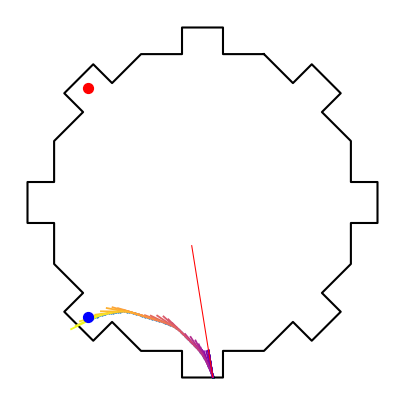

In [598]:
plot_selected_headangle_vectors_colour_map(is_player_in_alcove_results=is_player_in_alcove_results, player_id=0, 
                                        vector_length=3, step=3, cmap=mpl.cm.plasma, rows=10, debug=False)


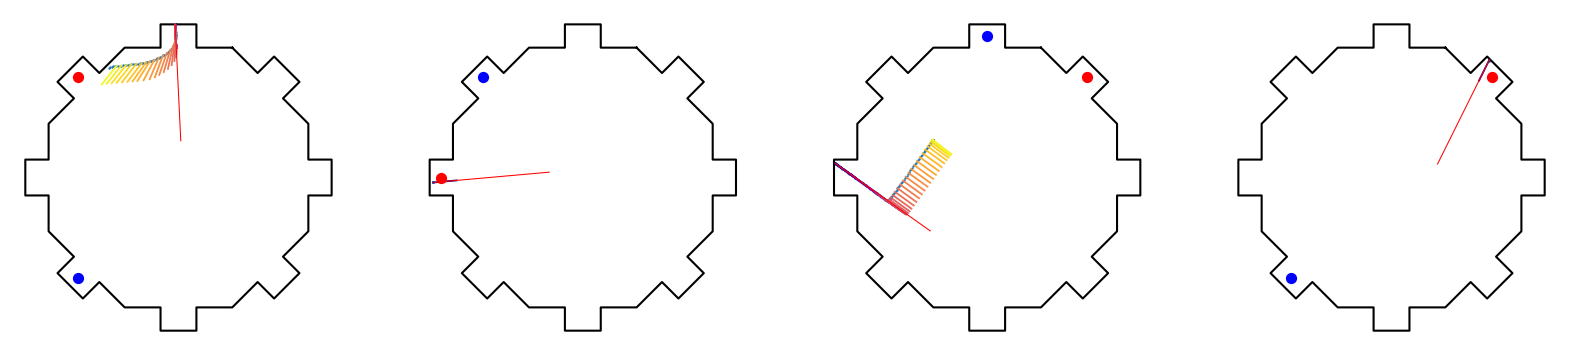

In [599]:
plot_selected_headangle_vectors_colour_map(is_player_in_alcove_results=is_player_in_alcove_results, player_id=1, 
                                        vector_length=3, step=3, cmap=mpl.cm.plasma, rows=10, debug=False)


SOLOS

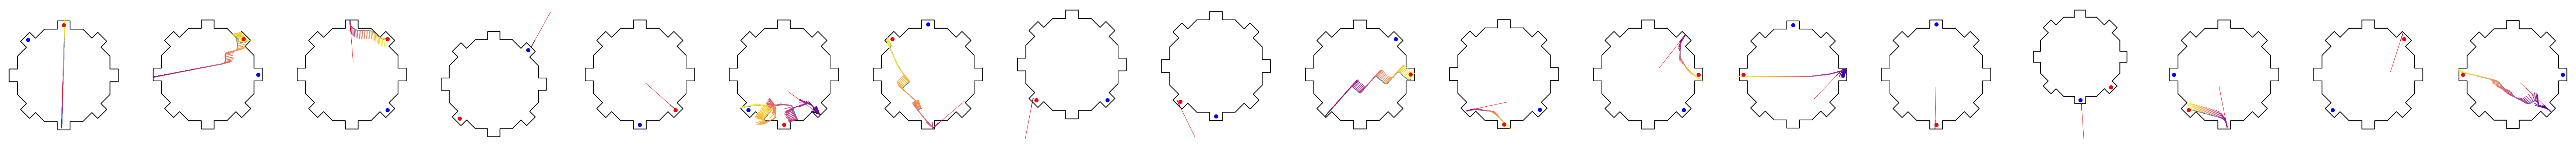

In [668]:
plot_selected_headangle_vectors_colour_map(is_player_in_alcove_results=is_player_in_alcove_results_solos, player_id=0, 
                                        vector_length=3, step=3, cmap=mpl.cm.plasma, rows=10, debug=False)

In [656]:
for i in range(8):
    print(wall_visible_dict[1][0][i])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  

In [520]:
past_alcove_indices_player1

{0: array([], shape=(0, 3), dtype=int64),
 1: array([], shape=(0, 3), dtype=int64),
 2: array([], shape=(0, 3), dtype=int64),
 3: array([], shape=(0, 3), dtype=int64),
 4: array([], shape=(0, 3), dtype=int64),
 5: array([], shape=(0, 3), dtype=int64),
 6: array([], shape=(0, 3), dtype=int64),
 7: array([[149,   0,   0],
        [149,   0,   1],
        [149,   0,   2],
        [149,   0,   3],
        [149,   0,   4]]),
 8: array([], shape=(0, 3), dtype=int64),
 9: array([], shape=(0, 3), dtype=int64),
 10: array([], shape=(0, 3), dtype=int64),
 11: array([], shape=(0, 3), dtype=int64),
 12: array([], shape=(0, 3), dtype=int64),
 13: array([], shape=(0, 3), dtype=int64),
 14: array([], shape=(0, 3), dtype=int64),
 15: array([], shape=(0, 3), dtype=int64),
 16: array([], shape=(0, 3), dtype=int64),
 17: array([], shape=(0, 3), dtype=int64),
 18: array([], shape=(0, 3), dtype=int64),
 19: array([], shape=(0, 3), dtype=int64),
 20: array([], shape=(0, 3), dtype=int64),
 21: array([], shap

In [440]:
past_alcove_array, past_alcove_indices = is_player_past_alcove(trial_list=trial_list, player_id=0, centre=(0,0), wall_num=8)

In [442]:
past_alcove_array[56, 4, 150]

np.int64(1)

In [499]:
past_alcove_indices

array([], shape=(0, 3), dtype=int64)

In [468]:
this_trial = extract_trial.extract_trial(trial_list[1], trial_list, 1)
trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=this_trial, player_id=1)
headangles = trajectory_vectors.extract_trial_player_headangles(trial=trial_list[1], player_id=1)
trial_player_headangles_smoothed = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles, window_size=5)

In [473]:
len(trial_player_headangles_smoothed[0])

96

In [472]:
len(headangles)


101

In [525]:
len(trial_list)

139

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall visible cannot be computed
wall vis

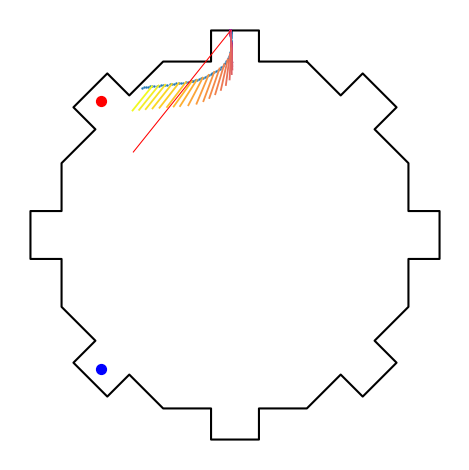

In [530]:
active_wall_visible = plot_headangle_vectors_colour_map(trial_list=trial_list, trial_index=149, timepoint=0, player_id=1, 
                                        vector_length=3, step=3, cmap=mpl.cm.plasma)

In [600]:
plot_octagon.return_octagon_path_points()

[(6.928483542969951, 16.726838936116845),
 (10.194602007352248, 13.460720471734547),
 (12.31592235091189, 15.582040815294189),
 (15.582040815294189, 12.31592235091189),
 (13.460720471734547, 10.194602007352248),
 (16.726838936116845, 6.928483542969952),
 (16.726838936116845, 2.309494514323318),
 (19.726838936116845, 2.309494514323318),
 (19.726838936116845, -2.3094945143233154),
 (16.726838936116845, -2.3094945143233154),
 (16.726838936116845, -6.92848354296995),
 (13.460720471734547, -10.194602007352248),
 (15.582040815294189, -12.31592235091189),
 (12.31592235091189, -15.582040815294189),
 (10.194602007352248, -13.460720471734547),
 (6.928483542969952, -16.726838936116845),
 (2.309494514323318, -16.726838936116845),
 (2.309494514323318, -19.726838936116845),
 (-2.3094945143233154, -19.726838936116845),
 (-2.3094945143233154, -16.726838936116845),
 (-6.928483542969949, -16.726838936116845),
 (-10.194602007352247, -13.46072047173455),
 (-12.315922350911888, -15.582040815294192),
 (-15.

In [620]:
# these are the points where the alcoves start along the octagon wall and where they end

# get vertex coordinates
vertex_x, vertex_y = plot_octagon.calculate_coordinates(vertex=True)

# get coordinates for the points 1/3 and 2/3 along each wall
wall_thirds_x, wall_thirds_y = plot_octagon.calculate_wall_thirds_coordinates(vertex_x, vertex_y)

# get coordinates for the alcove endpoints
alcove_x, alcove_y = plot_octagon.generate_alcove_endpoints(wall_thirds_x, wall_thirds_y, alcove_length_scaled, alcove_length_axis_projection)


In [635]:
wall_visible_dict = {}

for player_id in range(2):

    trial_lists = is_player_in_alcove_results[player_id]["alcove_trial_lists"]
    trial_indices = is_player_in_alcove_results[player_id]["trial_indices"]
    wall_visible_dict[player_id] = {}

    for i in range(len(trial_indices)):
        trial_list = trial_lists[i]
        trial_index = trial_indices[i]
        trial = trial_list[trial_index]
        wall_visible = trajectory_headangle.get_wall_visible(trial_list=trial_list, trial_index=trial_index, trial=trial, player_id=player_id, current_fov=110.36, debug=False)
        wall_visible_dict[player_id][i] = wall_visible



In [650]:
for i in range(len(wall_visible_dict[1])):
    if np.any(np.isnan(wall_visible_dict[1][i])):
        print(i)

1
3


In [ ]:
def ccw(p1,p2,p3):
    # if two segments intersect the path ABC should be in a different direction to path ABD
    # is the vector from p1 to p3 to the right of the vector from p1 to p2?
    return (p3[1]-p1[1])*(p2[0]-p1[0]) > (p2[1]-p1[1])*(p3[0]-p1[0])
def is_the_player_facing_alcove_wall(A1, A2, P1, P2):
# use ccw operation to check if two segments intersect
# segments are alcove wall defined by (wall_thirds_x, wall_thirds_y) and (alcove_x, alcove_y)
# and player head angle vector from given point on trajectory
    return ccw(A1,P1,P2) != ccw(A2,P1,P2) and ccw(A1,A2,P1) != ccw(A1,A2,P2)


The below function uses the same logic as the player-past-alcove-centre function but using one of the alcove entrance points as reference
- buggy atm needs adjusting

In [16]:
# is the player inside the alcove within a specific window of time?

def is_player_in_alcove_timewindow(trial_list=trial_list, player_id=0, centre=(0,0), wall_num=8, timepoint=0, window=5):
    '''
    Returns a binary array of shape (number of trials, number of walls, timepoints)
    indicating whether the player was past the defined wall thirds at the indexed time point over the course of the trial
    '''
    # get vertex coordinates
    vertex_x, vertex_y = plot_octagon.calculate_coordinates(vertex=True)

    # get coordinates for the points 1/3 and 2/3 along each wall
    wall_thirds_x, wall_thirds_y = plot_octagon.calculate_wall_thirds_coordinates(vertex_x, vertex_y)
    
    centre = centre
    centre_x = centre[0]
    centre_y = centre[1]

    # compute direction vector from arena centre to alcove centre
    alcove_vectors = np.full((8,2), 0, dtype=float)
    vector_units = np.full((8,2), 0, dtype=float)

    # for every wall get the tuples of x's and y's that defin the alcove entrance
    wall_third_tuples_x = []
    wall_third_tuples_y = []

    for i in range(8):
        k = i*2
        wall_third_tuple_x = wall_thirds_x[k:k+2]
        wall_third_tuple_y = wall_thirds_y[k:k+2]

        wall_third_tuples_x.append(wall_third_tuple_x)
        wall_third_tuples_y.append(wall_third_tuple_y)

    for i in range(8):
        alcove_x = wall_third_tuples_x[i][0]
        alcove_y = wall_third_tuples_y[i][0]
        alcove_vector = np.array([alcove_x - centre_x, alcove_y - centre_y])
        for j in range(2):
            alcove_vectors[i][j] = alcove_vector[j]

        vector_units[i] = alcove_vectors[i]/np.linalg.norm(alcove_vectors[i])

    x = (len(trial_list))
    y = wall_num
    z = max([len((trajectory_vectors.extract_trial_player_trajectory(trial=(extract_trial.extract_trial(trial_list[i], trial_list, i)), player_id=player_id))[0]) for i in range(x)])

    in_alcove_array = np.full((x, y, z), 0, dtype=int)
    # projected_depths = np.full((x,y,z), 0, dtype=float)

    for trial_index in range(len(trial_list)):

        this_trial = extract_trial.extract_trial(trial_list[trial_index], trial_list, trial_index)
        trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=this_trial, player_id=player_id)

        for w in range(window):
            time_index = timepoint + w

            if time_index < len(trajectory[0]):

                x_pos = trajectory[0][time_index]
                y_pos = trajectory[1][time_index]
                player_vector = ([x_pos - centre_x, y_pos - centre_y])

                for i in range(8):
                    projected_depth = np.dot(player_vector, vector_units[i])
                    #print(f"projected depth is {projected_depth}")
                    is_past_alcove = projected_depth > np.linalg.norm(alcove_vectors[i])
                    is_past_alcove = int(is_past_alcove)
                    #print(f"is past alcove? {is_past_alcove}")

                    in_alcove_array[trial_index][i][w] = is_past_alcove
            
            else:

                x_pos = trajectory[0][timepoint]
                y_pos = trajectory[1][timepoint]
                player_vector = ([x_pos - centre_x, y_pos - centre_y])

                for i in range(8):
                    projected_depth = np.dot(player_vector, vector_units[i])
                    is_past_alcove = projected_depth > np.linalg.norm(alcove_vectors[i])
                    is_past_alcove = int(is_past_alcove)

                    in_alcove_array[trial_index][i][timepoint] = is_past_alcove

            if in_alcove_array[trial_index][i][w] != 0:
                print(f"array {in_alcove_array[trial_index][i][timepoint]}, trial {trial_index}, wall {i}")
            #in_alcove_indices = 

    in_alcove_indices = np.argwhere(in_alcove_array == 1) 

    return in_alcove_array, in_alcove_indices

In [700]:
solo_list = trial_lists_solos[1]

In [811]:
in_alcove_array, in_alcove_indices = is_player_in_alcove_timewindow(trial_list=solo_list, player_id=0, centre=(0,0), wall_num=8, timepoint=0, window=5)


 array 1, trial 8, wall 7
 array 1, trial 8, wall 7
 array 1, trial 8, wall 7
 array 1, trial 8, wall 7
 array 1, trial 8, wall 7
 array 1, trial 15, wall 7
 array 1, trial 15, wall 7
 array 1, trial 15, wall 7
 array 1, trial 15, wall 7
 array 1, trial 15, wall 7
 array 1, trial 27, wall 7
 array 1, trial 28, wall 7
 array 1, trial 28, wall 7
 array 1, trial 28, wall 7
 array 1, trial 28, wall 7
 array 1, trial 28, wall 7
 array 1, trial 31, wall 7
 array 1, trial 31, wall 7
 array 1, trial 31, wall 7
 array 1, trial 31, wall 7
 array 1, trial 31, wall 7
 array 1, trial 44, wall 7
 array 1, trial 44, wall 7
 array 1, trial 44, wall 7
 array 1, trial 44, wall 7
 array 1, trial 44, wall 7
 array 0, trial 57, wall 7
 array 0, trial 57, wall 7
 array 0, trial 57, wall 7


In [17]:
in_alcove_indices_player_solos = {} 

for player_id in range(1):
    in_alcove_indices_player_solos[player_id] = {}
    
    for list_index in range(len(trial_lists_solos)):
        print(f"trial list index: {list_index}")
        in_alcove_array, indices_for_this_list = is_player_in_alcove_timewindow(
            trial_list=trial_lists_solos[list_index],
            player_id=player_id,
            centre=(0, 0),
            wall_num=8,
            timepoint=0,
            window=5
        )

        in_alcove_indices_player_solos[player_id][list_index] = indices_for_this_list

trial list index: 0
trial list index: 1
array 1, trial 8, wall 7
array 1, trial 8, wall 7
array 1, trial 8, wall 7
array 1, trial 8, wall 7
array 1, trial 8, wall 7
array 1, trial 15, wall 7
array 1, trial 15, wall 7
array 1, trial 15, wall 7
array 1, trial 15, wall 7
array 1, trial 15, wall 7
array 1, trial 27, wall 7
array 1, trial 28, wall 7
array 1, trial 28, wall 7
array 1, trial 28, wall 7
array 1, trial 28, wall 7
array 1, trial 28, wall 7
array 1, trial 31, wall 7
array 1, trial 31, wall 7
array 1, trial 31, wall 7
array 1, trial 31, wall 7
array 1, trial 31, wall 7
array 1, trial 44, wall 7
array 1, trial 44, wall 7
array 1, trial 44, wall 7
array 1, trial 44, wall 7
array 1, trial 44, wall 7
array 0, trial 57, wall 7
array 0, trial 57, wall 7
array 0, trial 57, wall 7
trial list index: 2
array 1, trial 1, wall 7
array 1, trial 1, wall 7
array 1, trial 1, wall 7
array 1, trial 1, wall 7
array 1, trial 1, wall 7
array 1, trial 23, wall 7
array 1, trial 23, wall 7
array 1, trial

In [18]:
in_alcove_indices_player_socials = {} 

for player_id in range(2):
    in_alcove_indices_player_socials[player_id] = {}
    
    for list_index in range(len(trial_lists)):
        print(f"trial list index {list_index}, length {len(trial_lists[list_index])}")
        in_alcove_array, indices_for_this_list = is_player_in_alcove_timewindow(
            trial_list=trial_lists[list_index],
            player_id=player_id,
            centre=(0, 0),
            wall_num=8,
            timepoint=0,
            window=5
        )

        in_alcove_indices_player_socials[player_id][list_index] = indices_for_this_list

trial list index 0, length 149
trial list index 1, length 122
trial list index 2, length 139
trial list index 3, length 137
trial list index 4, length 146
array 1, trial 30, wall 7
array 1, trial 30, wall 7
array 1, trial 30, wall 7
array 1, trial 30, wall 7
array 1, trial 30, wall 7
array 1, trial 54, wall 7
array 1, trial 54, wall 7
array 1, trial 54, wall 7
array 1, trial 54, wall 7
array 1, trial 54, wall 7
array 1, trial 76, wall 7
array 1, trial 76, wall 7
array 1, trial 76, wall 7
array 1, trial 76, wall 7
array 1, trial 76, wall 7
array 1, trial 110, wall 7
array 1, trial 110, wall 7
array 1, trial 110, wall 7
array 1, trial 110, wall 7
array 1, trial 110, wall 7
trial list index 5, length 139
trial list index 6, length 139
trial list index 7, length 150
array 1, trial 23, wall 7
array 1, trial 23, wall 7
array 1, trial 23, wall 7
array 1, trial 23, wall 7
array 1, trial 23, wall 7
array 1, trial 24, wall 7
array 1, trial 24, wall 7
array 1, trial 24, wall 7
array 1, trial 24, 

In [19]:
is_player_inside_alcove_results_solos = {}

# Iterate over players
for player_id in range(1):
    # Initialize empty lists per player
    alcove_trial_lists = []
    solo_files_indices = []
    trial_indices = []

    # Iterate over the trials
    for i in range(len(in_alcove_indices_player_solos[player_id])):
        # this asks whether there are trial indices identified as player-in-alcove trials in the trial list i
        if len(in_alcove_indices_player_solos[player_id][i]) > 0:
            # Append values to lists
            solo_files_indices.append(i)
            filename = ordered_solos[i]
            _, trial_list = prepare_data.prepare_data(data_folder, filename, combine=False)
            alcove_trial_lists.append(trial_list)
            for j in range(0,len(in_alcove_indices_player_solos[player_id][i]),5):
                trial_index = in_alcove_indices_player_solos[player_id][i][j][0]
                print(f"trial list: {i}, trial index: {trial_index}, alcove wall: {in_alcove_indices_player_solos[player_id][i][0][1]}")

                trial_indices.append(trial_index)

    # Save the full lists for this player
    is_player_inside_alcove_results_solos[player_id] = {
        "alcove_trial_lists": alcove_trial_lists,
        "solo_files_indices": solo_files_indices,
        "trial_indices": trial_indices
    }



filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250417_1/2025-04-17_12-09-51_CY17_FirstSolo.json
Loading complete.
Preprocessing complete.
trial list: 0, trial index: 37, alcove wall: 4
trial list: 0, trial index: 46, alcove wall: 4
trial list: 0, trial index: 47, alcove wall: 4
trial list: 0, trial index: 48, alcove wall: 4
trial list: 0, trial index: 49, alcove wall: 4
trial list: 0, trial index: 51, alcove wall: 4
trial list: 0, trial index: 52, alcove wall: 4
trial list: 0, trial index: 53, alcove wall: 4
trial list: 0, trial index: 54, alcove wall: 4
trial list: 0, trial index: 55, alcove wall: 4
trial list: 0, trial index: 57, alcove wall: 4
trial list: 0, trial index: 58, alcove wall: 4
trial list: 0, trial index: 59, alcove wall: 4
trial list: 0, trial index: 60, alcove wall: 4
trial list: 0, trial index: 61, alcove wall: 4
trial list: 0, trial index: 62, alcove wall: 4
trial list: 0, trial index: 63, alcove wall: 4

In [38]:
is_player_inside_alcove_results_socials = {}

# Iterate over players
for player_id in range(2):
    # Initialize empty lists per player
    alcove_trial_lists = []
    social_files_indices = []
    trial_indices = []

    # Iterate over the trials
    for i in range(len(in_alcove_indices_player_socials[player_id])):
        # this asks whether there are trial indices identified as player-in-alcove trials in trial list i
        if len(in_alcove_indices_player_socials[player_id][i]) > 0:
            # Append values to lists
            social_files_indices.append(i)
            filename = social_files[i]
            _, trial_list = prepare_data.prepare_data(data_folder, filename, combine=False)
            alcove_trial_lists.append(trial_list)
            for j in range(0,len(in_alcove_indices_player_socials[player_id][i]),5):
                trial_index = in_alcove_indices_player_socials[player_id][i][j][0]
                print(f"trial list: {i}, trial index: {trial_index}, player: {player_id}, alcove wall: {in_alcove_indices_player_socials[player_id][i][0][1]}")
                
                trial_indices.append(trial_index)

    # Save the full lists for this player
    is_player_inside_alcove_results_socials[player_id] = {
        "alcove_trial_lists": alcove_trial_lists,
        "social_files_indices": social_files_indices,
        "trial_indices": trial_indices
    }



filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/241112_2/2024-11-12_15-23-24_FA12_SL12_Social.json
Loading complete.
Preprocessing complete.
trial list: 1, trial index: 2, player: 0, alcove wall: 1
trial list: 1, trial index: 6, player: 0, alcove wall: 1
trial list: 1, trial index: 7, player: 0, alcove wall: 1
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250509_1/2025-05-09_12-30-13_AM09_MC09_Social.json
Loading complete.
Preprocessing complete.
trial list: 3, trial index: 48, player: 0, alcove wall: 1
trial list: 3, trial index: 64, player: 0, alcove wall: 1
filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250401_2/2025-04-01_15-29-49_AL01_NL01_Social.json
Loading complete.
Preprocessing complete.
trial list: 4, trial index: 7, player: 0, alcove wall: 4
trial list: 4, trial index: 8, player: 0, al

In [23]:
is_player_inside_alcove_results_socials[0]["social_files_indices"]

[1,
 3,
 4,
 5,
 6,
 7,
 9,
 11,
 16,
 17,
 19,
 20,
 21,
 22,
 23,
 24,
 27,
 29,
 30,
 34,
 36,
 37,
 45,
 46,
 47,
 48]

In [24]:
len(is_player_inside_alcove_results_socials[0]["social_files_indices"])

26

In [36]:
is_player_inside_alcove_results_socials[1]["social_files_indices"]

[0,
 1,
 2,
 3,
 4,
 6,
 7,
 11,
 12,
 13,
 17,
 19,
 21,
 22,
 23,
 24,
 27,
 29,
 30,
 32,
 33,
 34,
 35,
 37,
 38,
 45,
 46,
 47,
 48]

In [ ]:
len(is_player_inside_alcove_results_solos[0]["solo_files_indices"])

121

In [35]:
is_player_inside_alcove_results_socials[0]["trial_indices"]

[np.int64(2),
 np.int64(6),
 np.int64(7),
 np.int64(48),
 np.int64(64),
 np.int64(7),
 np.int64(8),
 np.int64(10),
 np.int64(11),
 np.int64(13),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(23),
 np.int64(24),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(31),
 np.int64(32),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(36),
 np.int64(37),
 np.int64(38),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(42),
 np.int64(43),
 np.int64(44),
 np.int64(45),
 np.int64(46),
 np.int64(47),
 np.int64(48),
 np.int64(50),
 np.int64(52),
 np.int64(53),
 np.int64(54),
 np.int64(55),
 np.int64(56),
 np.int64(57),
 np.int64(58),
 np.int64(59),
 np.int64(60),
 np.int64(61),
 np.int64(62),
 np.int64(63),
 np.int64(64),
 np.int64(65),
 np.int64(66),
 np.int64(67),
 np.int64(68),
 np.int64(72),
 np.int64(74),
 np.int64(76),
 np.int64(77),
 np.int64(78),
 np.int64(79),
 np.int64(80),
 np.int64(81),
 np.int64(82),
 np.int64(83),
 np.int64(84),
 np.int64(85),


Current player-in-alcove function picks up on trials where player is at the edge of the arena

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


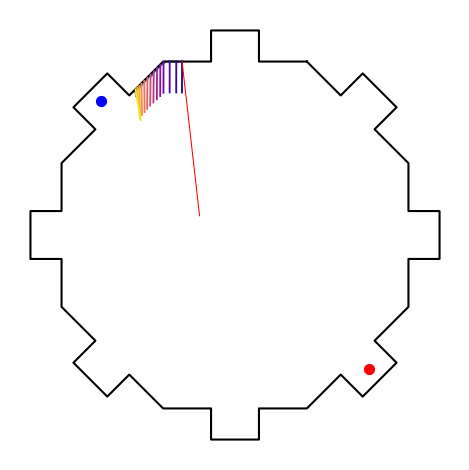

In [48]:
active_wall_visible = plot_headangle_vectors_colour_map(trial_list=trial_lists[48], trial_index=131, timepoint=0, player_id=0, 
                                        visibility_window=5, headangles_smoothing_window=5,
                                        vector_length=3, step=3, cmap=mpl.cm.plasma, ax=None, debug=False)

To do next:
1. Fix player-in-alcove function to only pick up trial where player is PAST the threshold and that should take care of trials such as the aboce